# Load Data

In [55]:
import sys
sys.path.append('..')

import torch
from network import components as cnn
from network import functional as F
from nlp import functional as nlp
import re
from tqdm.notebook import tqdm

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [56]:
DATAPATH = "C:\\Users\\jugwu\\Documents\\justins_work\\CNN\\cleanData\\"
PADDING = '<pad>'
START = '<start>'
END = '<end>'
NORM = None

num_samples = 5
max_seq = 10
EMBEDDINGS = 'embeddings8'

#cl.clean("text2", "clean")

In [57]:
def load_data(file, num:int=1, max_sequence_length:int=1):
    with open(DATAPATH + file + ".txt", 'r',encoding="utf-8") as f:
        lines = f.readlines()

    data_points = []
    data_labels = []

    for i, sentence in enumerate(lines):
        if i==0:
            continue
        if i >= num:
            break

        sentence = re.sub("\n", "", sentence)

        words = sentence.split(' ')
        words.append(END)
        words.insert(0, START)


        for j in range(len(words) - max_sequence_length):
            data_labels.append(words[j+1:j + max_sequence_length +1])
            data_points.append(words[j:j + max_sequence_length])

    for data, label in zip(data_points, data_labels):
        print(f"data: {data}, label: {label}")
        
    return data_points, data_labels

In [58]:
#data,labels = nlp.load_data("clean", num=2)
data2,labels2 = load_data("clean", num=num_samples, max_sequence_length=max_seq)
print(f"data: {np.size(data2)}, labels: {np.size(labels2)}")
tokens, vocab = nlp.tokenise("clean")

data: ['<start>', 'tanjiros', 'attack', 'completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower'], label: ['tanjiros', 'attack', 'completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank']
data: ['tanjiros', 'attack', 'completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank'], label: ['attack', 'completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to']
data: ['attack', 'completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to'], label: ['completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to', 'unleash']
data: ['completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to', 'unleash'], label: ['severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to', 'unleash', 'a']
data: ['severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to', 'unleash', 'a'], label: ['enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to', 'unleash', 'a', 'terrible']

In [59]:
def embedd(data, labels, file):
    vectors, tags = nlp.load_vectors("embeddings8")
    corpus = []
    
    for dat, lab in zip(data, labels):
        data_points = []
        data_labels = []
        for d, l in zip(dat,lab):
            data_points.append(vectors[tags.index(d)])
            label = torch.zeros(np.shape(tags)[0], dtype=torch.float)
            label[tags.index(l)] = 1
            data_labels.append(label)
        temp = []
        temp.append(torch.stack(data_points))
        temp.append(torch.stack(data_labels))
        corpus.append(temp)
        
    #print(corpus[0])
    #print(np.shape(corpus[0]))

    #corpus = torch.stack(corpus)
            
    return corpus

In [60]:
vocab_size = np.shape(tokens)[0]
train_data = embedd(data2,labels2, EMBEDDINGS)

trainloader = DataLoader(train_data, batch_size=30, shuffle=True)

for batch in trainloader:
    print(batch[0].size())
    print(batch[1].size())
    #print(batch[0])
    #print(batch[1])

vocab_size = np.shape(batch[1])[-1]

torch.Size([30, 10, 24])
torch.Size([30, 10, 419])
torch.Size([30, 10, 24])
torch.Size([30, 10, 419])
torch.Size([2, 10, 24])
torch.Size([2, 10, 419])


In [61]:
class FeedForwardNetwork():
    def __init__(self, d_model:int=512, ffn_hidden:int=2048, drop_prob:float=0.1):

        self.fc1 = cnn.FullyConnected(d_model, ffn_hidden,norm=NORM)
        self.relu = cnn.ReLu()
        self.fc2 = cnn.FullyConnected(ffn_hidden, d_model,norm=NORM)
        self.dropout = cnn.Dropout(drop_prob=drop_prob)

        return
    
    def forward(self, _input, training:bool = True):
        self.training = training
        residual = _input

        output = self.fc1.forward(_input)
        output = self.relu.forward(output)
        output = self.fc2.forward(output)
       
        if self.training:
            output = self.dropout.forward(output)
    
        output = cnn.layer_norm(output + residual)

        return output
    
    def back(self, gradient, param):

        residual = gradient
        
        if self.training:
            gradient = self.dropout.back(gradient, param)

        gradient = self.fc2.back(gradient, param)
        gradient = self.relu.back(gradient, param)
        gradient = self.fc1.back(gradient, param)
        gradient += residual
        
        return gradient

In [62]:
class FeedForwardNetworkCONV():
    def __init__(self, d_model:int=512, ffn_hidden:int=2048, max_seq_length:int=10):

        self.conv1 = cnn.Convolution_1D(input_size=max_seq_length, channels=ffn_hidden)#cnn.FullyConnected(d_model, ffn_hidden,norm=None)
        self.relu = cnn.ReLu()
        self.conv2 = cnn.Convolution_1D(input_size=max_seq_length, channels=d_model)
        
        return
    
    def forward(self, _input):

        residual = _input
        _input = torch.transpose(_input, -2,-1)
        output = self.conv1.forward(_input)
        output = self.relu.forward(output)
        output = self.conv2.forward(output)
        output = torch.transpose(output, -2,-1)
    
        norm_output = cnn.layer_norm(output + residual)

        return norm_output
    
    def back(self, gradient, param):

        residual = gradient
        gradient = torch.transpose(gradient, -2,-1)
        gradient = self.conv2.back(gradient, param)
        gradient = self.relu.back(gradient, param)
        gradient = self.conv1.back(gradient, param)
        gradient = torch.transpose(gradient, -2,-1)
        gradient += residual
        
        return gradient

In [63]:
class MultiHeadAttention():
    def __init__(self, d_model:int=512, num_heads:int=8,drop_prob:float=0.1):

        self.num_heads = num_heads
        self.linear_q = cnn.FullyConnected(d_model, d_model,norm=NORM)
        self.linear_k = cnn.FullyConnected(d_model, d_model,norm=NORM)
        self.linear_v = cnn.FullyConnected(d_model, d_model,norm=NORM)
        self.linear_out = cnn.FullyConnected(d_model, d_model,norm=NORM)
        self.softmax = cnn.Softmax()
        self.dropout = cnn.Dropout(drop_prob=drop_prob)
        
        return
    
    def forward(self, _input, mask=None,show:bool=False, training:bool = True):

        self.plot = show
        self.training=training

        self.batch_size, self.max_seq_length, self.d_model = _input.size()
        self.len_q = int(self.d_model/self.num_heads)

        residual = _input
        
        linear_Q = self.linear_q.forward(_input) #20 X 10 X 24
        linear_K = self.linear_k.forward(_input)
        linear_V = self.linear_v.forward(_input)

        Q_heads = linear_Q.reshape(self.batch_size, self.max_seq_length, self.num_heads, self.len_q) #20 X 10 X 8 X 3
        Q_heads = Q_heads.permute(0, 2, 1, 3) #20 X 8 X 10 X 3
        K_heads = linear_K.reshape(self.batch_size, self.max_seq_length, self.num_heads, self.len_q)
        K_heads = K_heads.permute(0, 2, 1, 3)
        V_heads = linear_V.reshape(self.batch_size, self.max_seq_length, self.num_heads, self.len_q)
        V_heads = V_heads.permute(0, 2, 1, 3)

        values = self.scaled_dot_product(Q_heads, K_heads, V_heads,mask=mask) #20 X 8 X 10 X 3
        
        values = values.reshape(self.batch_size, self.max_seq_length, self.d_model) #20 X 10 X 24

        output = self.linear_out.forward(values)

        if self.training:
            output = self.dropout.forward(output)
            
        output = cnn.layer_norm(output + residual)
        
        return output
    
    def back(self, gradient, param):

        #print(torch.sum(gradient))

        residual = gradient
        #gradient = cnn.layer_norm(gradient)
        
        if self.training:
            gradient = self.dropout.back(gradient, param)
        
        gradient = self.linear_out.back(gradient, param)

        #scaled dot product stuff_______________

        gradient = gradient.reshape(self.batch_size, self.num_heads, self.max_seq_length, self.len_q)

        #der Attention / der V
        d_V = self.scores.transpose(-2,-1) @ gradient#tick

        #der Attention / der Scores
        gradient = gradient @ self.V.transpose(-2,-1)#tick

        #der Scores / der Dot
        gradient = self.softmax.back(gradient, param)

        #der Dot / der Q
        d_Q = (gradient @ self.K/self.d_k)#tick

        #der Dot / der K
        d_K = (gradient.transpose(-2,-1) @ self.Q/self.d_k)#tick

        #print(f"q: {d_Q.size()}, k: {d_K.size()}, v: {d_V.size()}")

        d_Q = d_Q.permute(0, 2, 1, 3)
        d_K = d_K.permute(0, 2, 1, 3)
        d_V = d_V.permute(0, 2, 1, 3)
        
        #print(f"q: {d_Q.size()}, k: {d_K.size()}, v: {d_V.size()}")

        d_Q = d_Q.reshape(self.batch_size, self.max_seq_length, self.d_model)
        d_K = d_K.reshape(self.batch_size, self.max_seq_length, self.d_model)
        d_V = d_V.reshape(self.batch_size, self.max_seq_length, self.d_model)
        
        print(f"q: {d_Q.sum()}, k: {d_K.sum()}, v: {d_V.sum()}")
        
        #scaled dot product stuff_______________
        

        grad_Q = self.linear_q.back(d_Q, param)
        grad_K = self.linear_k.back(d_K, param)
        grad_V = self.linear_v.back(d_V, param)

        gradient = grad_Q + grad_K + grad_V

        #print(torch.sum(gradient))

        gradient += residual
        
        #print(torch.sum(gradient))

        return gradient
    
    def scaled_dot_product(self,Q,K,V, mask=None):

        full_mask = torch.zeros((self.max_seq_length, self.max_seq_length)) + float('-inf')
        full_mask = torch.triu(full_mask, diagonal=1) 
        full_mask = full_mask.unsqueeze(0).unsqueeze(0).expand(self.batch_size, self.num_heads,-1,-1)
        #print(f"Q: {Q}")
        #print(f"V: {V}")

        self.d_k = self.len_q ** (1/2)
        self.Q, self.K, self.V = Q, K, V

        attention_weights = (Q @ K.transpose(-2,-1))/self.d_k

        if mask is not None:
            mask = mask.unsqueeze(1).expand(-1,self.num_heads,-1,-1)
            full_mask = full_mask +  mask

        attention_weights += full_mask

        self.scores = self.softmax.forward(attention_weights)

        if self.plot:
            for i in range(self.num_heads):
                plt.imshow(self.scores[-1][i])
                plt.show()
                break
        #print(self.scores[-1][0])
        attention = self.scores @ V

        return attention
    

In [64]:
class DecoderLayer():
    def __init__(self, d_model:int=512, num_heads:int=8, ffn_hidden:int=2048,drop_prob:float=0.1):

        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads, drop_prob=drop_prob)
        self.ffn_net = FeedForwardNetwork(d_model=d_model, ffn_hidden=ffn_hidden, drop_prob=drop_prob)
        
        return
    
    def forward(self, _input, mask=None, show:bool=False, training:bool = True):

        out = self.self_attention.forward(_input, mask=mask,show=show, training=training)
        out = self.ffn_net.forward(out)

        return out
    
    def back(self, gradient, param):

        gradient = self.ffn_net.back(gradient, param)
        gradient = self.self_attention.back(gradient, param)
        
        return gradient

In [65]:
class DecoderModel():
    def __init__(self, d_model:int=512, num_heads:int=8, ffn_hidden:int=2048, num_layers:int=2, vocab_size:int=10, drop_prob:float=0.1):

        self.layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, ffn_hidden=ffn_hidden, drop_prob=drop_prob) for _ in range(num_layers)]
        self.linear = cnn.FullyConnected(d_model, vocab_size, norm=NORM)
        self.softmax = cnn.Softmax()
        self.postional_encoding = cnn.PostionalEncoding()
        self.init_pad = True

        return
    
    def forward(self, _input, show:bool=False, training:bool = True):
        
        if self.init_pad:
            self.pad_tensor = torch.zeros_like(_input[0][0], dtype=torch.float)
            self.init_pad = False

        mask = (_input == self.pad_tensor.unsqueeze(0).unsqueeze(0).expand(_input.size()[0], _input.size()[1],-1)).float()
        mask = (mask @ torch.transpose(mask,-2,-1))
        #print(pad_mask)
        mask = torch.where(torch.clamp(mask, max=1) == 1, float('-inf'), 0)
        self.mask = torch.tril(mask, diagonal=-1) 
        #embedd

        #encode
        out = self.postional_encoding.encode(_input)

        #decoder layers
        for layer in self.layers:
            out = layer.forward(out, mask=self.mask, show=show, training=training)
        
        #linear classifier
        out = self.linear.forward(out)
        out = self.softmax.forward(out)

        return out
    
    def backward(self, gradient, lr:float=0.001, optim=None,optim_lr:float=0.9, optim_b1:float=0.9, optim_b2:float=0.999):

        
        _parameters = {
            'lr' : lr,
            'optimiser' : optim,
            'optimiser_lr' : optim_lr,
            'optimiser_b1' : optim_b1,
            'optimiser_b2' : optim_b2
        }

        gradient = self.softmax.back(gradient, _parameters)
        gradient = self.linear.back(gradient, _parameters)

        for layer in self.layers[::-1]:
            gradient = layer.back(gradient, _parameters)

        return gradient

In [66]:
class TrainManager(object):
    def __init__(self, train, test, val = None):
        self.train_loader = train
        self.test_loader = test
        self.val_loader = val
        self.history = {
            'train_loss' : [],
            'validation_loss' : [],
            'train_accuracy' : [],
            'validation_accuracy' : [],
            'test_accuracy' : []
        }
        return
    
    def one_hot(self, number):
        result = torch.zeros(10, dtype=torch.float)
        result[number] = 1.0
        return result

    def train(self, _model, loss_func = F.MSELoss, epochs:int=1, lr:float=0.001, optim_b1:float=0.9, optim_b2:float=0.999, num_batches:int=1, optimiser='adam', decay:bool=False, loss_plot:bool=False):
       
        count = 0

        if decay:
            decay = lr/epochs

        for epoch in tqdm(range(epochs)):

            total = 0
            correct = 0
            batch_count = 0

            #batches = int(3000 / 128)

            for train_batch in self.train_loader:

                size = np.shape(train_batch)[0]
                

                if decay:
                    lr *= (1/(1 + decay * (epoch * num_batches + total)))

                count+=1
                total+=1

                _input = train_batch[0]
                _label = train_batch[1]

                result = _model.forward(_input)
                _loss = loss_func.calculate(result, _label)
                _model.backward(loss_func.back(), lr=lr, optim=optimiser, optim_b1=optim_b1, optim_b2=optim_b2)
                self.history['train_loss'].append(_loss)

                
                corr_ten = (torch.argmax(result, dim=-1) == torch.argmax(_label, dim=-1)).float()
                correct += torch.mean(corr_ten) 
                self.history['train_accuracy'].append((correct/total) * 100)

                if loss_plot:
                    self.plot_loss_accuracy()

                #if self.history['train_accuracy'][-1] > 15.0:
                    #break
                print(f"Epoch: {epoch}, it: {count}/{size * epochs} [train_loss: {self.history['train_loss'][-1]:.7f}], [train_accuracy: {self.history['train_accuracy'][-1]:.1f}]")
        
        self.trained_model = _model

        return
    
    def test(self, num_batches:int=100, num_examples:int=1):

        total = 0
        correct = 0
        batch_count = 0

        for test_batch in tqdm(self.test_loader):
            size = np.shape(test_batch)[0]
            total+=1
            
            _input = test_batch[0]
            _label = test_batch[1]

            result = self.trained_model.forward(_input)    
            corr_ten = (torch.argmax(result, dim=-1) == torch.argmax(_label, dim=-1)).float()
            correct += torch.mean(corr_ten) 

            self.history['test_accuracy'].append((correct/total) * 100)

        result = self.trained_model.forward_show(_input, _label, num_examples)   
        print(f"[test_accuracy: {sum(self.history['test_accuracy'])/len(self.history['test_accuracy'])}]")

        return
    
    def plot_loss_accuracy(self):
        
        clear_output(wait=True)
        fig, ax = plt.subplots(2)
        
        ax[0].plot(self.history['train_loss'], label="train_loss")
        #ax[0].plot(self.history['val_loss'], label="validation_loss")
        #ax[0].set_ylim(0, 0.2)
        #ax[0].set_xlim(0, self.data_size)
        ax[0].legend()
        
        ax[1].plot(self.history['train_accuracy'], label="train_accuracy")
        #ax[1].plot(self.history['valid_accuracy'], label="validation_accuracy")
        ax[1].set_ylim(0, 100)
        #ax[1].set_xlim(0, self.data_size)
        ax[1].legend()
        plt.show()
        
        return

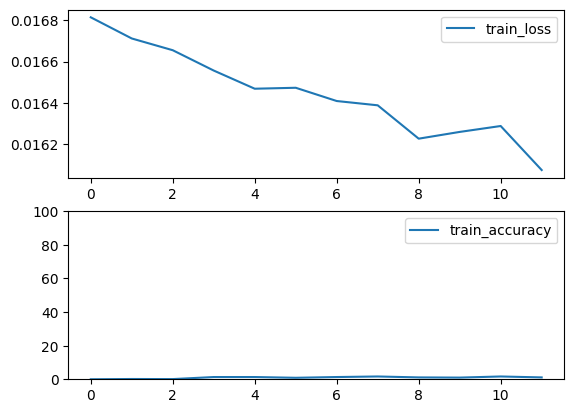

Epoch: 3, it: 12/8 [train_loss: 0.0160769], [train_accuracy: 1.1]


In [67]:
model = DecoderModel(d_model=24, num_layers=2, vocab_size=vocab_size, drop_prob=0.1)

loss_function = F.BinaryCrossEntropyLoss()
trial = TrainManager(train=trainloader, test=trainloader)
trial.train(model, loss_func=loss_function, num_batches=20, epochs=4, lr=0.0002, loss_plot=True)

In [68]:
def generate_old(_model, _start = '<start>', num:int=10, _show=False):
    start = [PADDING] * num
    #print(start)
    start[-1] = _start
    #print(start)
    _vectors, _vocab = nlp.load_vectors(EMBEDDINGS)
    start_vect = []
    for word in start:
        start_vect.append(_vectors[vocab.index(word)])
    
    start_vect = torch.stack(start_vect)
    start_vect = start_vect.unsqueeze(0)
    #print(start_vect.size())
    sentence = _start 
    
    for i in range(num):
        token_index = torch.argmax(_model.forward(start_vect,show=False,training=False)[:,i])
        temp = start_vect[:, 1:].clone()
        start_vect[:, :-1] = temp
        start_vect[:, -1] = _vectors[token_index]
        sentence = sentence + ' ' + _vocab[token_index]
        if _show:
            for index in torch.argmax(_model.forward(start_vect,training=False)[0], dim=1):
                print(_vocab[index])
            print("______________")

    print(sentence)
    return

In [69]:
def generate(_model, _start = '<start>', num:int=10, show:bool=False):
    start = [PADDING] * (num + 1)
    #print(start)
    start[0] = _start
    #print(start)
    _vectors, _vocab = nlp.load_vectors(EMBEDDINGS)
    start_vect = []
    for word in start:
        start_vect.append(_vectors[vocab.index(word)])
    
    start_vect = torch.stack(start_vect)
    start_vect = start_vect.unsqueeze(0)
    #print(start_vect.size())
    sentence = _start 
    
    for i in range(num):
        token_index = torch.argmax(_model.forward(start_vect,training=False)[:,i])
        start_vect[:, i+1] = _vectors[token_index]
        sentence = sentence + ' ' + _vocab[token_index]
        if show:
            for index in torch.argmax(_model.forward(start_vect,training=False)[0], dim=1):
                print(_vocab[index])
            print("______________")


    print(sentence)
    return

In [71]:
generate(model, num=max_seq)
generate(model, num=max_seq, _start='tanjiros')

<start> are are are are are are are are are are
tanjiros are are are are are are are are are are
